# Problem 7 (20 points)

## Problem Description
As a lecture activity, you performed support vector classification on a linearly separable dataset by solving the quadratic programming optimization problem to create a large margin classifier.

Now, you will use a similar approach to create a soft margin classifier on a dataset that is not cleanly separable.

Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the lecture activities.*

#### Summary of deliverables:
Functions (described later):
- `soft_margin_svm(X,y,C)`

Results:
- Print the values of w1, w2, and b for the C=0.05 case

Plots:
- Plot the data with the optimized margin and decision boundary for the case C=0.05
- Make 4 such plots for the requested C values

Discussion:
- Respond to the prompt asked at the end of the notebook

#### Imports and Utility Functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def plot_boundary(x, y, w1, w2, b, e=0.1):
    x1min, x1max = min(x[:,0]), max(x[:,0])
    x2min, x2max = min(x[:,1]), max(x[:,1])
    
    xb = np.linspace(x1min,x1max)
    y_0 = 1/w2*(-b-w1*xb)
    y_1 = 1/w2*(1-b-w1*xb)
    y_m1 = 1/w2*(-1-b-w1*xb)
    
    cmap = ListedColormap(["purple","orange"])

    plt.scatter(x[:,0],x[:,1],c=y,cmap=cmap)
    plt.plot(xb,y_0,'-',c='blue')
    plt.plot(xb,y_1,'--',c='green')
    plt.plot(xb,y_m1,'--',c='green')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.axis((x1min-e,x1max+e,x2min-e,x2max+e))

## Load data
Data is loaded as follows:  
- X: input features, Nx2 array  
- y: output class, length N array

In [2]:
data = np.load("data/w4-hw1-data.npy")
X = data[:, 0:2]
y = data[:, 2]

## Soft Margin SVM Optimization Problem

For soft-margin SVM, we introduce N slack variables $\xi_i$ (one for each point), and reformulate the optimization problem as:

$$
\min_{\boldsymbol{w}, b}\qquad \frac{1}{2}||\boldsymbol{w}||^2 + C \sum_i \xi_i
$$

$$
\text{subject to:}\quad y_i(\boldsymbol{w}^T \boldsymbol{x}_i+b)\geq 1 - \xi_i;\quad \xi_i \geq 0
$$

To put this into a form compatible with `cvxopt`, we will need to assemble large matrices as described in the next section.


## Soft Margin SVM function

Define a function `soft_margin_svm(X, y, C)` with inputs:
- `X`: (Nx2) array of input features
- `y`: Length N array of output classes, -1 or 1
- `C`: Regularization parameter

In this function, do the following steps:

1. Create the P, q, G, and h arrays for this problem (each comprised of multiple sub-matrices you need to combine into one)
- `P`: (3+N) x (3+N)
  - Upper left: Identity matrix, but with 0 instead of 1 for the bias (third) row/column
  - Upper right (3xN): Zeros
  - Lower left (Nx3): Zeros
  - Lower right: (NxN): Zeros
- `q`: (3+N) x (1)
  - Top (3x1): Vector of zeros
  - Bottom (Nx1): Vector filled with 'C'
- `G`: (N+N) x (N+3): 
  - Upper left (Nx3): Negative y multiplied element-wise by [`x1`, `x2`, `1`]
  - Upper right (NxN): Negative identity matrix
  - Lower left (Nx3): Zeros
  - Lower right (NxN): Negative identity matrix
- `h`: (N+N) x (1)
  - Top: Vector of -1
  - Bottom: Vector of zeros

You can use `np.block()` to combine multiple submatrices into one.

2. Convert each of these into cvxopt matrices (Provided)

3. Solve the problem using `cvxopt.solvers.qp` (Provided)

4. Extract the `w1`, `w2`, and `b` values from the solution, and return them (Provided)

In [12]:
def soft_margin_svm(X, y, C):
    N = np.shape(X)[0]

    # YOUR CODE GOES HERE
    # Define P, q, G, h
    P = np.ones([3,3])
    P[-1,-1] = 0
    P = np.concatenate([np.concatenate([P,np.zeros([3,N])],axis=1),np.zeros([N,3+N])],axis=0)
    q = np.concatenate([np.zeros(3), C*np.ones(N)]).reshape(-1,1)
    G = np.array([np.array(-y*X[:,0]), np.array(-y*X[:,1]), np.ones(N)]).T
    G = np.concatenate([np.concatenate([np.array([np.array(-y*X[:,0]), np.array(-y*X[:,1]), np.ones(N)]).T,-1*np.eye(N)],axis=1),
                        np.concatenate([np.zeros([N,3]), np.eye(N)],axis=1)],axis=0)
    h = np.concatenate([-1*np.ones(N), np.zeros(N)]).reshape(-1,1)

    z = solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h))
    w1 = z['x'][0]
    w2 = z['x'][1]
    b  = z['x'][2]

    return w1, w2, b

## Demo: C = 0.05
Run the cell below to create the plot for the N = 0.05 case

In [15]:
C = 0.05
w1, w2, b = soft_margin_svm(X, y, C)
print(f"\nSolution\n--------\nw1: {w1:8.4f}\nw2: {w2:8.4f}\n b: {b:8.4f}")

plt.figure()
plot_boundary(X,y,w1,w2,b,e=1)
plt.title(f"C = {C}")
plt.show()


Solution
--------
w1:   0.2852
w2:   0.1083
 b:  -5.1126


[70.54322256 69.56741235 68.59160213 67.61579192 66.63998171 65.6641715
 64.68836129 63.71255108 62.73674087 61.76093066 60.78512045 59.80931023
 58.83350002 57.85768981 56.8818796  55.90606939 54.93025918 53.95444897
 52.97863876 52.00282855 51.02701833 50.05120812 49.07539791 48.0995877
 47.12377749 46.14796728 45.17215707 44.19634686 43.22053665 42.24472643
 41.26891622 40.29310601 39.3172958  38.34148559 37.36567538 36.38986517
 35.41405496 34.43824475 33.46243453 32.48662432 31.51081411 30.5350039
 29.55919369 28.58338348 27.60757327 26.63176306 25.65595285 24.68014264
 23.70433242 22.72852221]
[-8.8594     -8.48885714 -8.11831429 -7.74777143 -7.37722857 -7.00668571
 -6.63614286 -6.2656     -5.89505714 -5.52451429 -5.15397143 -4.78342857
 -4.41288571 -4.04234286 -3.6718     -3.30125714 -2.93071429 -2.56017143
 -2.18962857 -1.81908571 -1.44854286 -1.078      -0.70745714 -0.33691429
  0.03362857  0.40417143  0.77471429  1.14525714  1.5158      1.88634286
  2.25688571  2.62742857  2.

## Varying C
Now loop over the C values [1e-5, 1e-3, 1e-2, 1] and generate soft margin decision boundary plots like the one above for each case.


Solution
--------
w1:   0.2445
w2:   0.0855
 b:  -4.2860

Solution
--------
w1:   0.2390
w2:   0.0847
 b:  -4.2852

Solution
--------
w1:   0.2244
w2:   0.0842
 b:  -4.4127

Solution
--------
w1:   0.8141
w2:   0.2148
 b: -10.6458


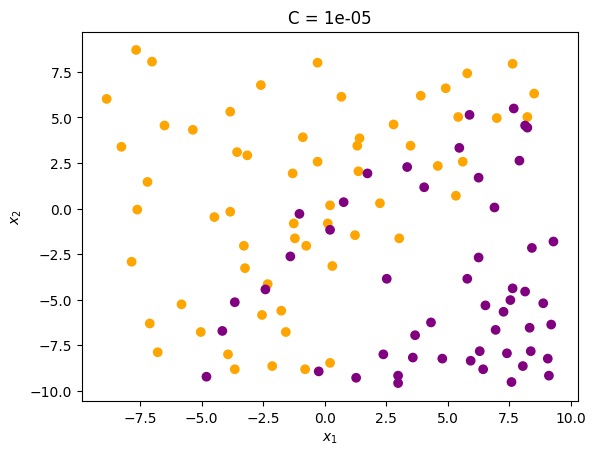

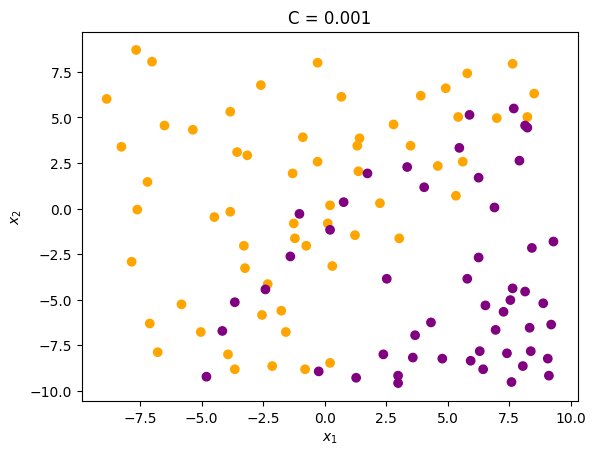

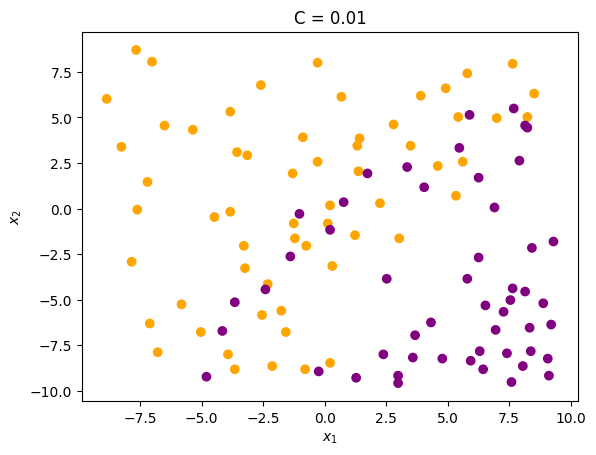

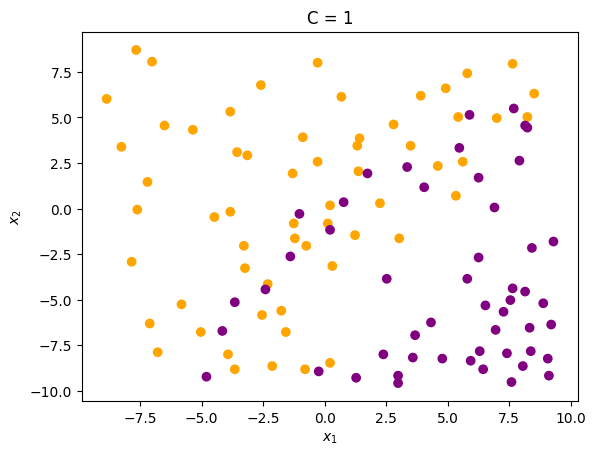

In [14]:
Cs = [1e-5, 1e-3, 1e-2, 1]
for C in Cs:
    w1, w2, b = soft_margin_svm(X, y, C)
    print(f"\nSolution\n--------\nw1: {w1:8.4f}\nw2: {w2:8.4f}\n b: {b:8.4f}")

    plt.figure()
    plot_boundary(X,y,w1,w2,b,e=1)
    plt.title(f"C = {C}")

plt.show()

## Discussion

Please write a sentence or two discussing what happens to the decision boundary and margin as you vary C, and try to provide some rationale for why.